# 1) 데이터 선정 이유 및 문제 정의

### 우리의 신체는 시간이 지날수록 근력과 유연성, 협응력 등 다양한 기능들이 쇠퇴하고 수행능력이 떨어집니다.  
### 구체적으로 시간의 지남에 따라 어떤 특성이 변화했기에 종합적인 신체 수행능력이 저하되는지 알아보기 위하여 다음과 같은 데이터를 선정하고 분석하였습니다.

아래의 데이터는 서울올림픽기념 국민체육진흥공단에서 관리하고 있는 국민체력측정데이터의 항목별 측정 정보를 제공하는 (신체 성능)데이터입니다.  
연령대, 신장, 체중, 윗몸일으키기, 제자리 멀리뛰기 등의 체력측정 항목별 결과를 조회할 수 있습니다.  

- age : 나이
- gender : 성별
- height_cm : 신장
- weight_kg : 체중
- body fat_% : 체지방률
- diastolic : 이완기 혈압(분당)
- systolic : 수축기 혈압(분당)
- gripForce : 악력
- sit and bend forward_cm : 앉아서 앞으로 구부리기(유연성)
- sit-ups counts : 윗몸 일으키기 횟수
- broad jump_cm : 멀리뛰기
- class : 등급

In [77]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [78]:
# 라이브러리

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [80]:
# 데이터 확인

df = pd.read_csv('/content/drive/My Drive/bodyPerformance.csv')
df.head(10)

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B
5,36.0,F,165.4,55.40,22.0,64.0,119.0,23.8,21.0,27.0,153.0,B
6,42.0,F,164.5,63.70,32.2,72.0,135.0,22.7,0.8,18.0,146.0,D
7,33.0,M,174.9,77.20,36.9,84.0,137.0,45.9,12.3,42.0,234.0,B
8,54.0,M,166.8,67.50,27.6,85.0,165.0,40.4,18.6,34.0,148.0,C
9,28.0,M,185.0,84.60,14.4,81.0,156.0,57.9,12.1,55.0,213.0,B


# 2) 데이터를 이용한 가설 및 평가지표, 베이스라인 선택


**특정 변수들을 입력데이터로 넣었을 시 출력되는 (종합 수행능력)등급을 예측하고 싶다. : 분류문제**  



In [81]:
# 타겟 설정 및 타입과 최빈값 확인

target = 'class'
print(f'타겟특성의 데이터 타입 : {df[target].dtypes}\n')
print('타겟특성의 대표값 확인')
print(df[target].value_counts())
print(df[target].mode())

타겟특성의 데이터 타입 : object

타겟특성의 대표값 확인
D    3349
C    3349
A    3348
B    3347
Name: class, dtype: int64
0    C
1    D
dtype: object


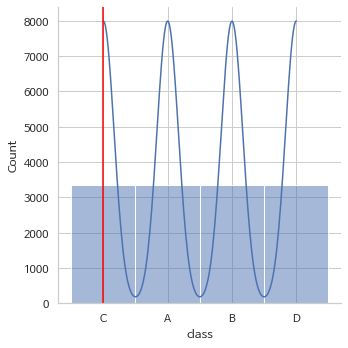

In [82]:
# 기준모델

sns.displot(df[target], kde=True);
plt.axvline(df[target].mode().any(), color='red');

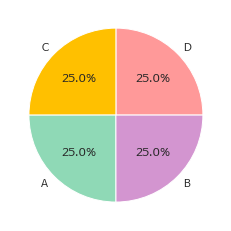

In [83]:
# 시각화

color = ['#8B4513','#A0522D','#D2691E','#CD853F','#F4A460','#DEB887']
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']

ratio = list(df[target].value_counts().values)
labels = list(df[target].value_counts().index)

plt.pie(ratio, labels=labels, autopct='%.1f%%', colors=colors)
plt.show()

데이터가 균형적이므로 평가지표는 정확도(accuracy)를 사용할 것이다.

# 3) EDA와 데이터 전처리

In [84]:
df.shape

(13393, 12)

데이터가 충분히 크다

In [85]:
df.isnull().sum()

age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64

결측값 없음

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


gender 와 class 만 object 형태

In [87]:
# 통계치 확인
df.describe().T.style.bar(
    subset=['mean'],
    color='#606ff2').background_gradient(
    subset=['std'], cmap='PuBu').background_gradient(subset=['50%'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
age,13393.000000,36.775106,13.625639,21.000000,25.000000,32.000000,48.000000,64.000000
height_cm,13393.000000,168.559807,8.426583,125.000000,162.400000,169.200000,174.800000,193.800000
weight_kg,13393.000000,67.447316,11.949666,26.300000,58.200000,67.400000,75.300000,138.100000
body fat_%,13393.000000,23.240165,7.256844,3.000000,18.000000,22.800000,28.000000,78.400000
diastolic,13393.000000,78.796842,10.742033,0.000000,71.000000,79.000000,86.000000,156.200000
systolic,13393.000000,130.234817,14.713954,0.000000,120.000000,130.000000,141.000000,201.000000
gripForce,13393.000000,36.963877,10.624864,0.000000,27.500000,37.900000,45.200000,70.500000
sit and bend forward_cm,13393.000000,15.209268,8.456677,-25.000000,10.900000,16.200000,20.700000,213.000000
sit-ups counts,13393.000000,39.771224,14.276698,0.000000,30.000000,41.000000,50.000000,80.000000
broad jump_cm,13393.000000,190.129627,39.868000,0.000000,162.000000,193.000000,221.000000,303.000000


In [88]:
# 남자 통계치 확인
df[df.gender == 'M'].describe().T

,count,mean,std,min,25%,50%,75%,max
age,8467.0,36.149167,13.103067,21.0,25.0,32.0,45.0,64.0
height_cm,8467.0,173.257399,5.810007,145.8,169.3,173.1,177.1,193.8
weight_kg,8467.0,73.580187,9.468653,36.5,67.3,72.8,79.0,138.1
body fat_%,8467.0,20.188151,5.952703,3.0,16.0,20.0,24.0,78.4
diastolic,8467.0,80.669411,10.350981,6.0,74.0,81.0,88.0,126.0
systolic,8467.0,133.870072,13.563141,14.0,123.0,134.0,144.0,201.0
gripForce,8467.0,43.448420,7.170091,0.0,38.8,43.3,48.1,70.5
sit and bend forward_cm,8467.0,13.097073,8.441618,-25.0,8.8,14.2,18.3,213.0
sit-ups counts,8467.0,44.939176,11.729377,0.0,37.0,46.0,54.0,80.0
broad jump_cm,8467.0,211.541526,28.267162,0.0,194.0,214.0,231.0,303.0


In [89]:
# 여자 통계치 확인
df[df.gender == 'F'].describe().T

,count,mean,std,min,25%,50%,75%,max
age,4926.0,37.850995,14.417859,21.0,24.000,34.0,51.0,64.0
height_cm,4926.0,160.485404,5.648771,125.0,156.600,160.5,164.3,179.0
weight_kg,4926.0,56.905899,7.639541,26.3,51.965,55.9,61.0,113.3
body fat_%,4926.0,28.486085,6.224667,3.5,24.100,28.3,32.6,53.5
diastolic,4926.0,75.578197,10.639717,0.0,68.000,75.0,83.0,156.2
systolic,4926.0,123.986399,14.515961,0.0,114.000,123.0,133.0,184.0
gripForce,4926.0,25.817994,4.695002,0.0,22.700,25.6,28.8,45.5
sit and bend forward_cm,4926.0,18.839791,7.149408,-22.0,15.300,20.0,23.5,35.2
sit-ups counts,4926.0,30.888348,13.888988,0.0,21.000,32.0,41.0,74.0
broad jump_cm,4926.0,153.326025,28.381922,0.0,135.000,156.0,173.0,260.0


Feature Engineering

In [90]:
# age 특성 형변환

df['age'] = df['age'].astype(int)
df['age'].dtypes

dtype('int64')

In [91]:
# 연령대 특성 생성

df['age_group'] = 0

In [92]:
age_group_list = []
for age in df['age']:
  if 20 <= age <= 29:
    age_group_list.append(20)
  elif 30 <= age <= 39:
    age_group_list.append(30)
  elif 40 <= age <= 49:
    age_group_list.append(40)
  elif 50 <= age <= 59:
    age_group_list.append(50)
  else:
    age_group_list.append(60)

df['age_group'] = age_group_list
df

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,age_group
0,27,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C,20
1,25,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A,20
2,31,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C,30
3,32,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B,30
4,28,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25,M,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,C,20
13389,21,M,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,D,20
13390,39,M,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,A,30
13391,64,F,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,D,60


In [93]:
# 특성 순서 바꿔서 합치기

df = pd.concat([df['age'], df['age_group'], df[df.columns[1:-1]]], axis=1)
df.head()

,age,age_group,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27,20,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25,20,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31,30,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32,30,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28,20,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [94]:
# 특성이름 수정

df.rename(columns={'class':'Class'},inplace=True)

범주형 데이터 인코딩

In [95]:
# 남자: 1, 여자: 0
df.gender = df.gender.map({'M':1,'F':0}).astype('int')

In [96]:
# A: 0 , B: 1, C: 2, D: 3
oe=OrdinalEncoder(dtype='int')
df.Class=oe.fit_transform(df.Class.values.reshape(-1,1)).reshape(1,-1)[0]

In [97]:
# 인코딩 후
df

,age,age_group,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,Class
0,27,20,1,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,2
1,25,20,1,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0
2,31,30,1,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,2
3,32,30,1,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,1
4,28,20,1,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25,20,1,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,2
13389,21,20,1,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,3
13390,39,30,1,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,0
13391,64,60,0,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,3


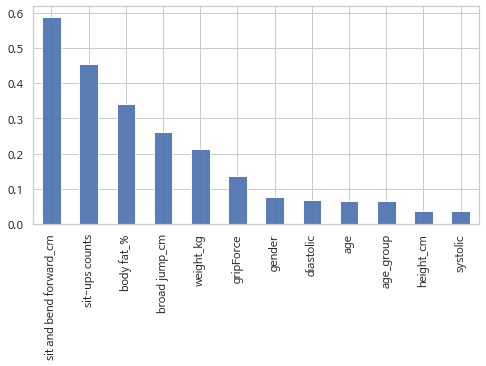

In [98]:
# Class 특성의 상관관계 확인
df.corr().Class.sort_values(ascending=False)[1:].abs().sort_values(ascending=False).plot(kind='bar',figsize=(8,4),alpha=.92);

Class 와 가장 높은 상관관계를 갖고 있는 특성들은 앉아서 앞으로 구부리기, 윗몸 일으키기 횟수, 체지방률, 멀리뛰기 및 체중이다.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


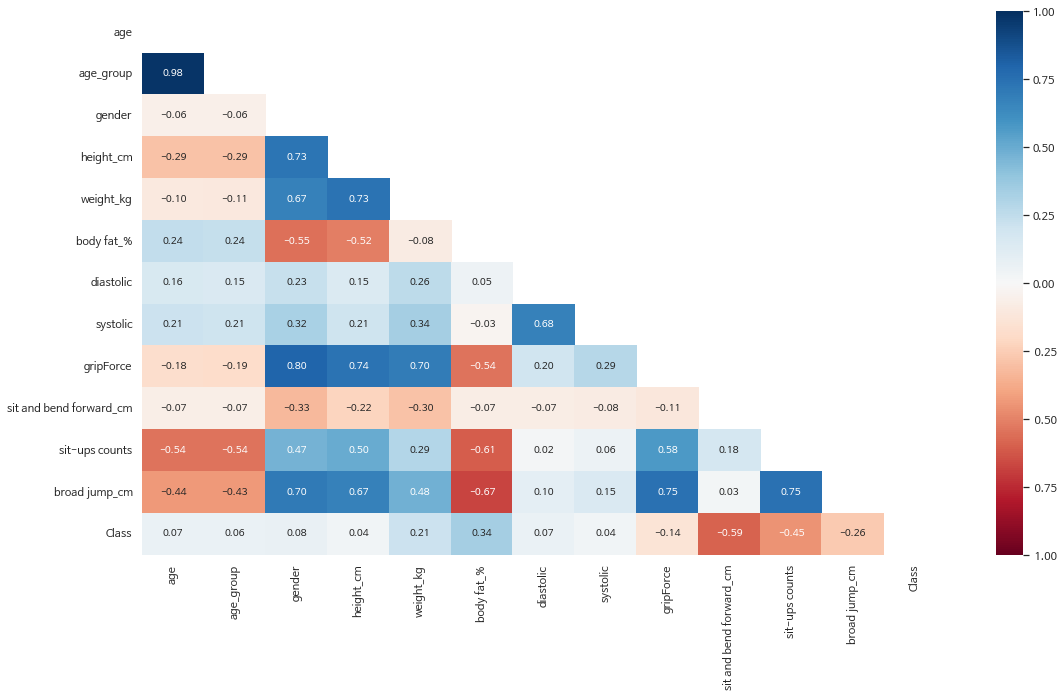

In [99]:
# 시각화 1
plt.figure(figsize=(18,10))
mask = np.triu(np.ones_like(df.corr()))
sns.heatmap(df.corr(),annot=True,fmt='.2f',mask=mask,annot_kws={"size":10},cmap='RdBu',vmin=-1,vmax=1);

- 성별과 체지방률, 키와 체지방률, 키/체중 및 성별 등과 같은 여러 기능 간에는 상당한 상관관계가 있다.
- 나이와 윗몸 일으키기 횟수 사이의 음의 상관관계는 젊은 사람들이 나이가 많은 사람들보다 수행능력이 더 좋은 경향이 있음을 의미한다. (멀리뛰기도 마찬가지)
- 키와 몸무게 사이에는 0.73의 양의 상관관계가 있고 키와 체지방률 사이에는 -0.52의 음의 상관관계가 있어 키가 큰 사람이 키가 작은 사람보다 체지방률이 낮은 경향이 있음을 알 수 있다.
- 체지방률과 특정 특성(멀리뛰기, 윗몸 일으키기 횟수, 악력) 사이에는 약간의 음의 상관관계가 있었는데, 이는 체지방률이 낮은 사람들이 멀리뛰기, 윗몸 일으키기 및 악력에 있어서 더 좋은 수행능력을 보이는 경향이 있음을 시사한다.
- 이완기 혈압 및 수축기 혈압 간에는 0.68의 양의 상관관계가 있다.


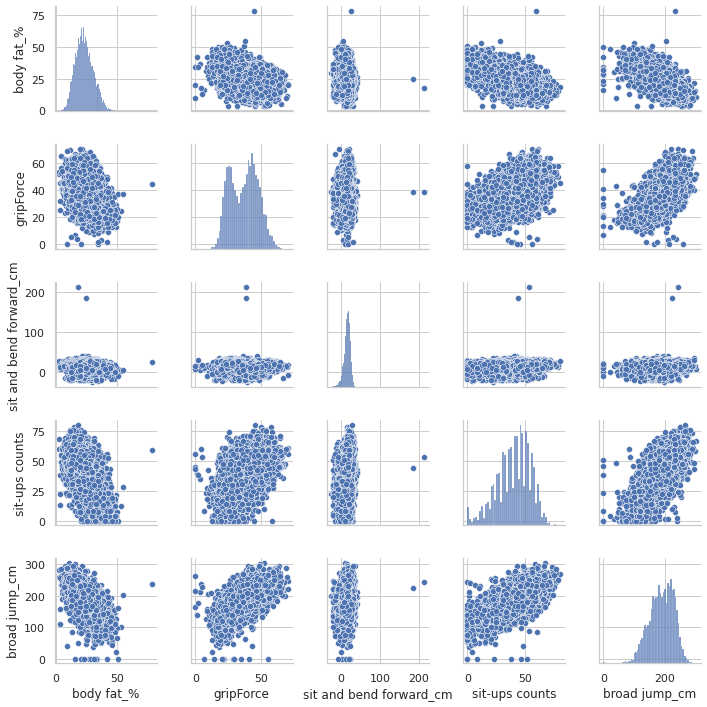

In [100]:
# 시각화 2
sns.set(style='whitegrid', context='notebook')
cols = ['body fat_%','gripForce', 'sit and bend forward_cm','sit-ups counts','broad jump_cm']
sns.pairplot(df[cols], height=2);

체지방률은 대부분의 특성들과 음의 상관관계를 보인다. (체지방률이 높을수록 수행능력이 떨어진다.)

In [101]:
# 20대, 30대, 40대, 50대, 60대 남녀 그룹 평균 체지방률(body fat_%)

df_20s = df.groupby('age_group').get_group(20)
df_30s = df.groupby('age_group').get_group(30)
df_40s = df.groupby('age_group').get_group(40)
df_50s = df.groupby('age_group').get_group(50)
df_60s = df.groupby('age_group').get_group(60)

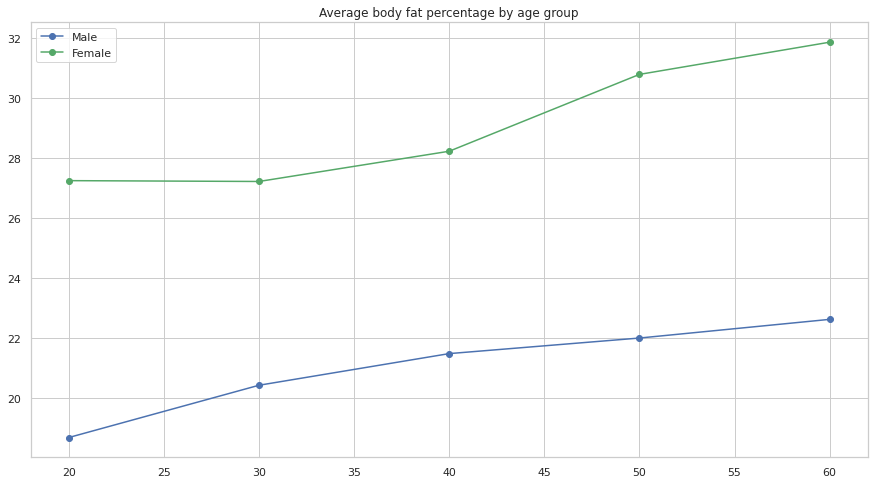

In [102]:
# 시각화

plt.figure(figsize=(15,8))
plt.plot(df.age_group.sort_values().unique(),[df_20s.groupby('gender').get_group(1)['body fat_%'].mean(),
                                              df_30s.groupby('gender').get_group(1)['body fat_%'].mean(),
                                              df_40s.groupby('gender').get_group(1)['body fat_%'].mean(),
                                              df_50s.groupby('gender').get_group(1)['body fat_%'].mean(),
                                              df_60s.groupby('gender').get_group(1)['body fat_%'].mean()],'bo-', label='Male')
plt.plot(df.age_group.sort_values().unique(),[df_20s.groupby('gender').get_group(0)['body fat_%'].mean(),
                                              df_30s.groupby('gender').get_group(0)['body fat_%'].mean(),
                                              df_40s.groupby('gender').get_group(0)['body fat_%'].mean(),
                                              df_50s.groupby('gender').get_group(0)['body fat_%'].mean(),
                                              df_60s.groupby('gender').get_group(0)['body fat_%'].mean()],'go-', label='Female')
plt.legend()
plt.title('Average body fat percentage by age group')
plt.show()

나이가 많을수록 평균체지방률이 높다는 것을 알 수 있다.

# 4) 머신러닝 방식 적용 및 교차검증

In [103]:
# 데이터 분리

X = df.drop('Class',axis=1)
y = df.Class

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=.2,random_state=0)
print(f"train size: {X_train.shape[0]} , validation size: {X_val.shape[0]}")

train size: 10714 , validation size: 2679


In [104]:
#Random Forest

rf=RandomForestClassifier(random_state=42,n_estimators=500)
rf.fit(X_train,y_train)
print(f"train score: {rf.score(X_train,y_train):.4f}")
print(f"test score: {rf.score(X_val,y_val):.4f}")

train score: 1.0000
test score: 0.7563


In [105]:
print(classification_report(y_val,rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       684
           1       0.64      0.66      0.65       651
           2       0.72      0.66      0.69       653
           3       0.91      0.83      0.87       691

    accuracy                           0.76      2679
   macro avg       0.76      0.75      0.75      2679
weighted avg       0.76      0.76      0.76      2679



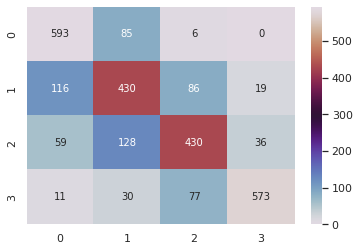

In [106]:
sns.heatmap(confusion_matrix(y_val,rf.predict(X_val)),annot=True,annot_kws={"size":10},cmap='twilight',fmt='.0f');

In [107]:
# XGBClassifier

xgbc=XGBClassifier(n_estimators=500, learning_rate=0.05)
xgbc.fit(X_train,y_train, early_stopping_rounds=5, eval_set=[(X_val,y_val)],verbose=False)
print(f"train score: {xgbc.score(X_train,y_train):.4f}")
print(f"test score: {xgbc.score(X_val,y_val):.4f}")

train score: 0.6384
test score: 0.6446


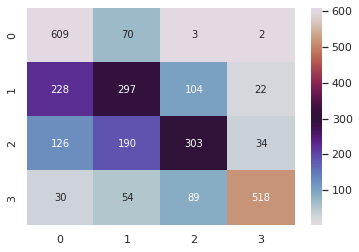

In [108]:
sns.heatmap(confusion_matrix(y_val,xgbc.predict(X_val)),annot=True,annot_kws={"size":10},cmap='twilight',fmt='.0f');

# 5) 머신러닝 모델 해석

참고자료

- https://www.kaggle.com/muladpham/body-performance-moranfitness
- https://www.kaggle.com/d4rklucif3r/body-performance-count-luciferml-eda-models